# Import Package

In [2]:
#dataframe
import pandas as pd

#computation
import numpy as np


#NLP lib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# string operations
import string 
import re

# general imports
import math

#visualization
import matplotlib.pyplot as plt

# Load Data

In [3]:
df = pd.read_csv('data.tsv', sep='\t',error_bad_lines=False)
df.head()

/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [4]:
df.dropna(inplace=True)

In [5]:
df.nunique()

id              363177
qid1            293839
qid2            273121
question1       265926
question2       272959
is_duplicate         2
dtype: int64

In [6]:
df.drop_duplicates(subset = ['question1'], keep = 'last',inplace=True)   #drop duplicates for question 1
df.drop_duplicates(subset = ['question2'], keep = 'last',inplace=True)   #drop duplicates for question 2

<AxesSubplot:>

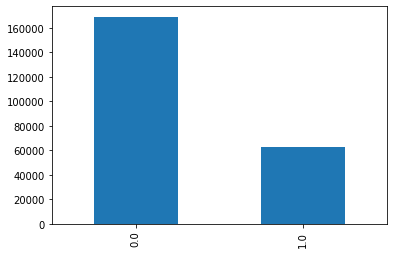

In [7]:
df['is_duplicate'].value_counts().plot(kind='bar')

### Test Set

In [8]:
df.reset_index(inplace=True)

In [9]:
df_test = df[df['is_duplicate'] == 1].iloc[:100]

# Text Preprocessing Function (from last assignment)

In [10]:
def remove_stopwords(review):
    """
    function to remove stopword
    """
    stopwords_list=set(stopwords.words('english'))
    tokens = nltk.word_tokenize(review)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopwords_list]
    
    review = ' '.join(filtered_tokens)    
    return review

In [11]:
def remove_punctuation(review: string):
    """
    function to remove punctuation for
    """
    punc_list = [i for i in string.punctuation]
    tokens = nltk.word_tokenize(review)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in punc_list]

    review = ' '.join(filtered_tokens)
    return review

In [12]:
def to_lowercase(review: string):
    """
    transfer all word to lowecase
    """
    return review.lower()

In [13]:
def lemmatizer(review: string):
    """
    function to perform lemmatization
    """
    wnl = WordNetLemmatizer()
    review = ' '.join([wnl.lemmatize(word) for word in review.split()])
    return review

In [14]:
def stemmer(review: string):
    """
    function to perform stemming
    """
    st=nltk.porter.PorterStemmer()
    review= ' '.join([st.stem(word) for word in review.split()])
    return review

In [15]:
def get_word_counts(words: list) -> dict:
    """
    function to count words given a list of words
    """
    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0.0) + 1.0 #update number of word in the dict
    return word_counts


### Preprocess the question2 corpus

In [16]:
df['processed_q2'] = df['question2'].apply(to_lowercase) #tolowercase
df['processed_q2'] = df['processed_q2'].apply(remove_stopwords) #remove stopword
df['processed_q2'] = df['processed_q2'].apply(remove_punctuation) #remove punctuation
df['processed_q2'] = df['processed_q2'].apply(lemmatizer) #lemmatization


In [17]:
get_word_counts(['Hello', 'yo', 'yo', 'ke', 'blah', 'blah'])

{'Hello': 1.0, 'yo': 2.0, 'ke': 1.0, 'blah': 2.0}

In [25]:
for row in df[:5]:
    print()

TypeError: string indices must be integers